In [24]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import np_utils
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore")

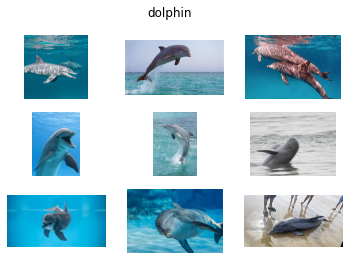

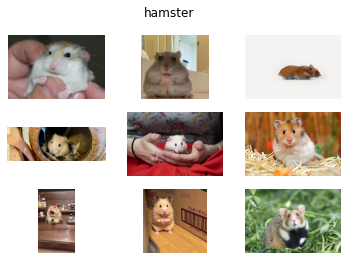

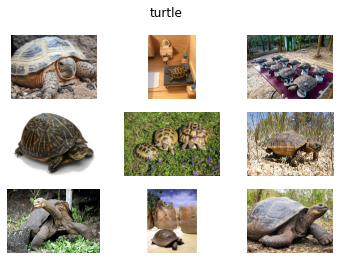

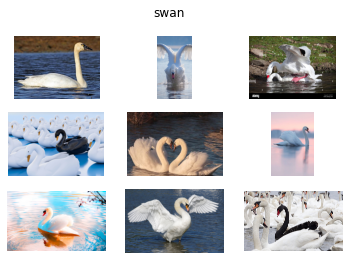

In [25]:
Path = r'C:/Users/Mattia/Desktop/DataScience/animals/'
animals = ['dolphin', 'hamster','turtle',"swan"]

for animal in animals:
    fig, _ = plt.subplots(3,3)
    fig.suptitle(animal)
    for k, v in enumerate(os.listdir(Path+animal)[:9]):
        img = plt.imread(Path+animal+'/'+v)
        plt.subplot(3, 3, k+1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

In [26]:
height = []
width = []

for animal in animals:
    for files in os.listdir(Path+animal):
        height.append(plt.imread(Path+animal+'/'+ files).shape[0])
        width.append(plt.imread(Path+animal+'/'+ files).shape[1])
    print(animal, ' => height min : ', min(height), 'width min : ', min(width))
    print(animal, ' => height max : ', max(height), 'width max : ', max(width))
    height = []
    width = []

dolphin  => height min :  100 width min :  100
dolphin  => height max :  4000 width max :  5370
hamster  => height min :  100 width min :  100
hamster  => height max :  4912 width max :  7360
turtle  => height min :  100 width min :  100
turtle  => height max :  3434 width max :  5150
swan  => height min :  100 width min :  100
swan  => height max :  3560 width max :  5405


In [58]:
# initialize the data and labels
feat = []
names = []
imagePaths = []
height = 32
width = 55
n_channels = 3

# grab the image paths and randomly shuffle them
for k, animal in enumerate(animals):
    for f in os.listdir(Path+animal):
        imagePaths.append([Path+animal+'/'+f, k]) # k=0 : 'dogs', k=1 : 'panda', k=2 : 'cats'

import random
random.shuffle(imagePaths)
#print(imagePaths[:10])

# loop over the input images
for imagePath in imagePaths:
    # load the image, resize the image to be HEIGHT * WIDTH pixels (ignoring
    # aspect ratio) and store the image in the data list
    image = cv2.imread(imagePath[0])
    image = cv2.resize(image, (width, height))  # .flatten()
    feat.append(image)
    
    # extract the class label from the image path and update the
    # labels list
    name = imagePath[1]
    names.append(name)

In [59]:
# scale the raw pixel intensities to the range [0, 1]
feat = np.array(feat, dtype="float") / 255.0
names = np.array(names)

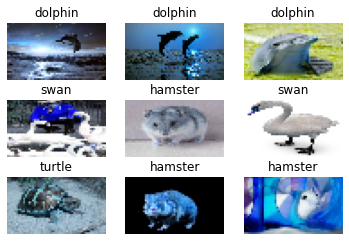

In [60]:
# Let's check everything is ok
plt.subplots(3,3)
for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(feat[i])
    plt.axis('off')
    plt.title(animals[names[i]])
plt.show()

In [61]:
(trainX, testX, trainY, testY) = train_test_split(feat, names, test_size=0.2, random_state=42, stratify=names)

In [62]:
# Preprocess class labels
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(548, 32, 55, 3)
(138, 32, 55, 3)
(548,)
(138,)


In [63]:
def build_model(hp):
    activation1 = hp.Choice("activation1", ["relu", "sigmoid", "selu","softmax"])
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model = Sequential()

    model.add(Conv2D(32, (2, 2), activation=activation1, input_shape=(height, width, n_channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (2, 2), activation=activation1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=activation1))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
    return model

def training(trainX, trainY, max_trials, executions_per_trial, overwrite, dir, project_name):
    # define the optimization algorithm
    tuner = kt.RandomSearch(build_model,
                            objective=kt.Objective("val_loss", direction ="min"),
                            max_trials=max_trials, # run model with different hyperparameter
                            executions_per_trial=executions_per_trial, # run model same hyperparameter
                            overwrite=overwrite,
                            directory=dir,
                            project_name=project_name
                            )

    history = tuner.search(trainX,
                            np_utils.to_categorical(trainY,4),
                            epochs=50,
                            validation_data=(testX, np_utils.to_categorical(testY,4)),
                            callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                     patience=5,
                                                                     mode="min",
                                                                     restore_best_weights=True)])

    print(" ")
    print(" ")
    print("RESULT SUMMARY ##################")
    tuner.results_summary()
    return tuner

In [66]:
directory = Path

overwrite = True # set this parameter equal to false to read models already saved
trials = 20
ex_trails = 2
prj = "image_recog"

In [68]:
tuner = training(trainX, trainY, trials, ex_trails, overwrite, directory, prj)
models = tuner.get_best_models(num_models=trials)

Trial 20 Complete [00h 00m 37s]
val_loss: 1.3832805156707764

Best val_loss So Far: 0.48995348811149597
Total elapsed time: 00h 15m 12s
INFO:tensorflow:Oracle triggered exit
 
 
RESULT SUMMARY ##################
Results summary
Results in C:/Users/Mattia/Desktop/DataScience/animals/image_recog
Showing 10 best trials
Trial summary
Hyperparameters:
activation1: relu
lr: 0.0005297126835427752
Score: 0.48995348811149597
Trial summary
Hyperparameters:
activation1: relu
lr: 0.0010817749459071228
Score: 0.5050425827503204
Trial summary
Hyperparameters:
activation1: relu
lr: 0.0014000116581985261
Score: 0.525365561246872
Trial summary
Hyperparameters:
activation1: relu
lr: 0.0008725920375456185
Score: 0.538011372089386
Trial summary
Hyperparameters:
activation1: relu
lr: 0.00019673616425971004
Score: 0.5463104844093323
Trial summary
Hyperparameters:
activation1: selu
lr: 0.000889004387467539
Score: 0.6283018589019775
Trial summary
Hyperparameters:
activation1: selu
lr: 0.0013653501948374237
Sc

In [69]:
models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 54, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 27, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 26, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 13, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 13, 32)         0         
                                                                 
 flatten (Flatten)           (None, 2912)              0

In [73]:
from sklearn.metrics import accuracy_score
best_model = tuner.get_best_models()[0]
predicted_classes = np.argmax(best_model.predict(testX), axis=-1)
accuracy_score(testY, predicted_classes)

5/5 [==============================] - 0s 10ms/step


0.8623188405797102

5/5 [==============================] - 0s 10ms/step
[3 3 0 3 2 2 3 3 2 3 3 2 3 1 2 2 3 1 1 2 0 2 1 0 1 1 2 1 2 3 3 3 1 3 3 2 2
 0 3 2 3 0 3 1 1 2 1 0 0 0 0 3 1 3 3 2 1 2 2 0 1 3 1 3 1 0 3 3 1 0 0 0 2 0
 1 1 2 3 1 0 3 2 0 1 1 0 1 3 0 3 0 2 3 2 0 0 1 1 0 0 3 1 0 1 3 0 3 0 1 3 2
 0 2 1 1 2 0 2 3 1 3 1 0 3 1 3 0 2 2 2 1 0 2 2 1 1 1 2]


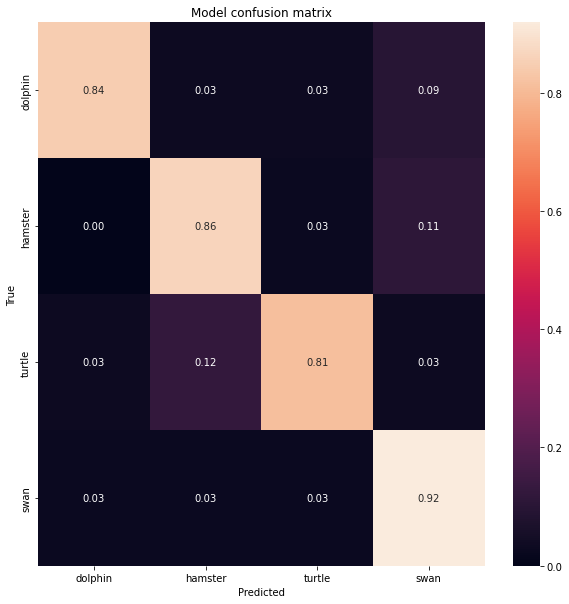

Total accuracy : 86.23%


In [94]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

best_model = tuner.get_best_models()[0]
predictions = np.argmax(best_model.predict(testX), axis=-1) # return to label
print(testY)
cm = confusion_matrix(testY, predictions)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Model confusion matrix')
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=animals, yticklabels=animals)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


accuracy = accuracy_score(testY, predictions)
print("Total accuracy : %.2f%%" % (accuracy*100.0))

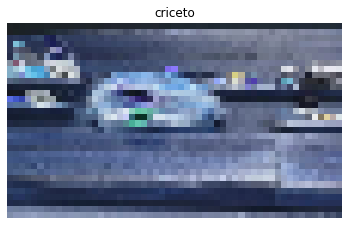

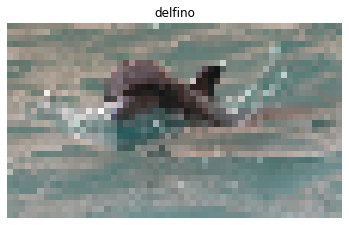

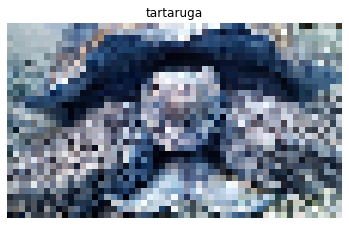

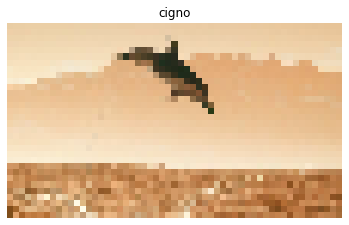

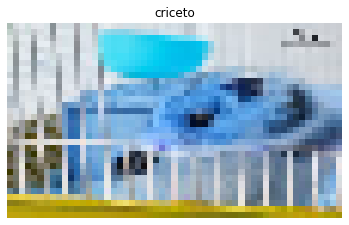

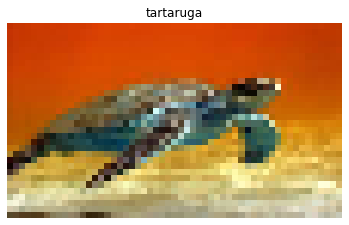

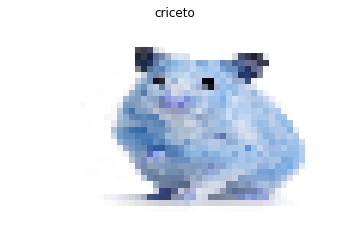

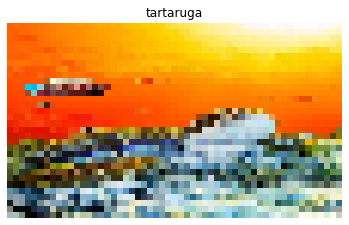

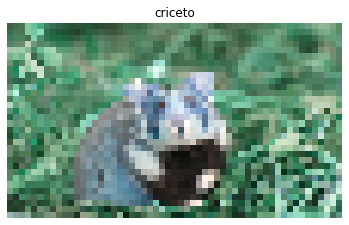

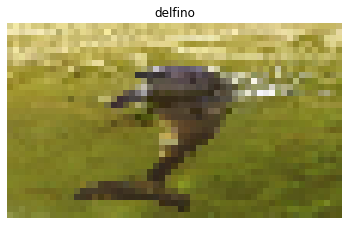

[1 0 2 3 1 2 1 2 1 0 2 3 3 0 2 2 2 3 2 2 2 0 0 1 3 3 2 1 0 3 2 3 1 0 1 2 0
 0 2 2 3 1 3 0 2 2 0 3 1 1 3 2 0 3 3 3 1 1 3 1 3 3 3 2 3 3 3 3 1 2 0 3 2 3
 2 0 3 2 3 1 3 0 0 3 0 3 0 2 3 3 0 1 2 1 3 2 3 3 2 1 1 2 3 2 3 0 2 3 3 2 0
 2 3 0 0 1 1 0 0 0 1 2 0 2 2 1 0 3 1 0 3 0 3 1 3 1 1 2 3 1 2 0 2 3 1 1 2 3
 2 1 2 1 3 3 3 2 1 1 2 2 1 1 3 3 0]
[1 0 2 0 1 2 1 2 1 0 2 3 3 0 2 2 2 3 2 2 3 0 3 1 3 0 2 1 0 3 2 3 1 0 1 2 0
 0 2 1 3 1 3 0 2 2 0 3 1 1 3 3 0 0 3 3 1 2 0 3 3 0 3 2 2 3 3 3 1 2 0 3 0 3
 2 0 3 2 2 1 3 0 0 3 0 1 0 2 0 3 0 1 2 1 3 2 3 3 2 1 1 2 3 0 2 0 2 3 3 1 0
 2 0 0 0 1 1 0 0 0 0 2 0 2 2 1 0 3 1 0 3 0 3 1 3 1 1 3 3 1 2 0 2 3 0 1 2 3
 2 1 0 1 3 0 3 2 1 3 2 3 1 1 3 3 0]


In [36]:
for i in range(10):
    plt.imshow(testX[i])
    plt.axis('off')
    plt.title(animals[predictions[i]])
    plt.show()